In [8]:
from keras.models import Model
from keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten
)
from keras.layers.convolutional import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D
)
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import numpy as np
import matplotlib.pyplot as plt

def _bn_relu(inputs):
    """
    BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(inputs)
    return Activation("relu")(norm)

def _conv_bn_relu(filters, kernel_size=(3, 3), strides=(1, 1)):
    """
    conv -> BN -> relu
    """
    def f(inputs):
        conv = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides,
                      padding='same', kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(inputs)
        norm = BatchNormalization(axis=CHANNEL_AXIS)(conv)
        return Activation("relu")(norm)
    return f

def _bn_relu_conv(filters, kernel_size=(3, 3), strides=(1, 1)):
    """
    BN -> relu -> conv
    """
    def f(inputs):
        norm = BatchNormalization(axis=CHANNEL_AXIS)(inputs)
        activation = Activation("relu")(norm)
        return Conv2D(filters=filters, kernel_size=kernel_size, strides=strides,
                      padding='same', kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(activation)
    return f

def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """
    basic residual block : 3*3 kernel
    """
    def f(inputs):
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(inputs)
        else:
            conv1 = _bn_relu_conv(filters, (3, 3), strides=init_strides)(inputs)
        residual = _bn_relu_conv(filters, (3, 3))(conv1)
        return _shortcut(inputs, residual)
    return f

def bottleneck(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """
    bottleneck : 1*1 filters -> 3*3 filters -> 1*1 4*filters
    """
    def f(inputs):
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(inputs)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=init_strides)(inputs)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        return _shortcut(inputs, residual)
    return f

def _shortcut(inputs, residual):
    input_shape = K.int_shape(inputs)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = residual._keras_shape[CHANNEL_AXIS] == inputs._keras_shape[CHANNEL_AXIS]

    shortcut = inputs
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual._keras_shape[CHANNEL_AXIS], kernel_size=(1, 1), strides=(stride_width, stride_height),
                          padding="valid", kernel_initializer="he_normal")(inputs)

    return add([shortcut, residual])

def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    def f(inputs):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            inputs = block_function(filters=filters, init_strides=init_strides,
                                    is_first_block_of_first_layer=(is_first_layer and i == 0))(inputs)
        return inputs
    return f


class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions):
        """Builds a custom ResNet like architecture.

        Args:
            input_shape: The input shape in the form (nb_rows, nb_cols, nb_channels)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved

        Returns:
            The keras `Model`.
        """
        assert input_shape[-1] == 3, 'must use channel_last format!'
        global ROW_AXIS, COL_AXIS, CHANNEL_AXIS
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
        
        inputs = Input(shape=input_shape)
        conv1 = _conv_bn_relu(filters=64, kernel_size=(7, 7), strides=(2, 2))(inputs)
        pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)

        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            filters *= 2

        # Last activation
        block = _bn_relu(block)

        # Classifier block
        block_shape = K.int_shape(block)
        pool2 = AveragePooling2D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS]),
                                 strides=(1, 1))(block)
        flatten1 = Flatten()(pool2)
        dense = Dense(units=num_outputs, kernel_initializer="he_normal", activation="softmax")(flatten1)

        model = Model(inputs=inputs, outputs=dense)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 2, 2, 2])

    @staticmethod
    def build_resnet_34(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_50(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_101(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 23, 3])

    @staticmethod
    def build_resnet_152(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 8, 36, 3])

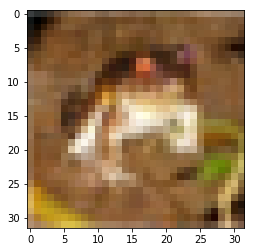

In [9]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
plt.imshow(X_train[0])
plt.show()

In [10]:
nb_classes = 10
# Convert class vectors to binary class matrices.
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# subtract mean and normalize
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_test -= mean_image
X_train /= 128.
X_test /= 128.

model = ResnetBuilder.build_resnet_18(X_train[0].shape, nb_classes)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [11]:
batch_size = 64

nb_epoch = 1

data_augmentation = False

if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(X_train, Y_train,
                      batch_size=batch_size,
                      epochs=nb_epoch,
                      validation_data=(X_test, Y_test))
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(X_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        validation_data=(X_test, Y_test),
                        epochs=nb_epoch, verbose=1, max_q_size=100)

Not using data augmentation.
Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 2887s - loss: 1.5323 - acc: 0.5534 - val_loss: 1.3837 - val_acc: 0.5971


In [13]:
model.evaluate(X_test, Y_test)

10000/10000 [==============================] - 51s    


[1.383679047012329, 0.59709999999999996]

abc